# 14. Particle filters 2

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gem-epidemics/practical-epidemics/blob/master/site/source/iddinf/14-particle-filters-2.ipynb)

**Date**: Thursday Sept 12, 2024

## The particles package

We will use the python package particles to implement the Bootstrap Filter. This package was developed to complement the book "An Introduction to Sequential Monte Carlo" by Chopin and Papaspiliopoulos. Details of the package are available:
https://pypi.org/project/particles/

This includes documentation with examples (on which some of the following is based).

The package can be installed with "pip install particles"

In [ ]:
!pip install particles

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 5.7 MB/s eta 0:00:00


First we import the package.

In [ ]:
import particles
import particles.state_space_models as ssm
import particles.distributions as dists
from particles.collectors import Moments

# standard libraries
import numpy as np
from matplotlib import pyplot as plt


## Defining a State Space Model

Particles works through specifying a State Space Model, and then has various functions for simulating from the model or for running the Bootstrap (or other) filters.

To define a State Space Model we need to define the initial distribution; the transition density and the likelihood.
These are defined in terms of functions in dists, see
https://particles-sequential-monte-carlo-in-python.readthedocs.io/en/latest/distributions.html#module-particles.distributions

A simple example is the following, a model with a linear-Gaussian state transition and observation model. (This model is tractable, with the filtering distributions able to be calculated by the Kalman filter -- but we will use it to understand how the Bootstrap filter works.)

In [ ]:
class LinearGaussianSSM(ssm.StateSpaceModel):
    default_params = {'sigma': 1., 'rho': 0.8, 'tau': 1., 'priorsd':1.}  # optional
    def PX0(self):  # Distribution of X_0
        return dists.Normal(scale=self.priorsd)  # X_0 ~ N(0, priorsd^2)
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}
        return dists.Normal(loc=self.rho * xp, scale=self.tau * np.sqrt( 1. - self.rho**2) )  # X_t ~ N( rho*X_{t-1}, tau^2*(1-rho^2))
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t (and X_{t-1})
        return dists.Normal(loc=x, scale=self.sigma)  # Y_t ~ N(X_t, sigma^2)

## Linear Gaussian Model Example

Write down the model corresponding to this code.

The above model has four parameters:
* ```sigma``` is the standard deviation of the observation;
*```tau``` is the marginal standard deviation of $X_t$ under the Markov model for the latent process;
* ```rho``` is the lag-1 autocorrelation; and
* ```priorsd``` is the standard deviatio of $X_0$.

We need to specify the value of these parameters to define a specific State Space Model to analyse. The following code defines a model for ```rho=0.5``` (and ```tau=1```, ```sigma=1``` as per the defaults), and then simulates data from this model.

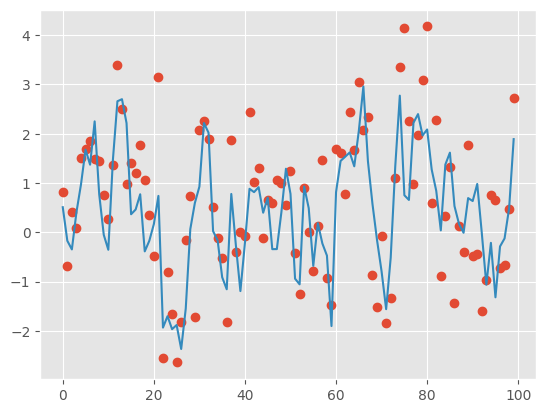

In [ ]:
linearssm = LinearGaussianSSM(rho=0.5)

true_states, data = linearssm.simulate(100) #simulate one hundred data points

plt.style.use('ggplot')
plt.figure()
plt.plot(data,'o') ##observations as points
plt.plot(true_states) ##state dynamics as line

For more detail about the basic ideas see
https://particles-sequential-monte-carlo-in-python.readthedocs.io/en/latest/notebooks/basic_tutorial.html

The following code defines and runs the bootstrap filter for this model.

To define the general boostrap filter we use ssm. Bootstrap whose arguments are the State Space model (```linearssm```) and the data (```data```).  We define this object as ```kf_model```.

We then define a specific instance of this bootstrap filter which requires the number of particles (```N```), the type of resampling, and the value of ESS/N below which we resample (set to 1, so the algorithm always resamples). We tell it to store the estimated moments of the filtering distribution (argument ```collect```).

In [ ]:
fk_model = ssm.Bootstrap(ssm=linearssm, data=data)  # we use the Bootstrap filter
bf = particles.SMC(fk=fk_model, N=100, resampling='residual', ESSrmin=1.,
                   collect=[Moments()])  # the algorithm
bf.run()  # actual computation


It is also possible to run the bootstrap filter one step at a time. See below and
https://particles-sequential-monte-carlo-in-python.readthedocs.io/en/latest/notebooks/advanced_tutorial_ssm.html#Running-a-particle-filter

This also gives details of what is stored from the run.

We can get the list of weighted particles, and the estimate of the log-likelihood.

In [ ]:
bf.X ## the particles #Note that bf.Xp ##the particles at the previous step

array([ 1.49979732,  0.05296468,  0.82510775, -0.32257268,  0.68875407,
       -0.53156723, -0.30699785,  0.41809854,  0.4795233 ,  0.43234095,
       -0.12056035,  1.10704737, -0.45575592, -0.58612115,  1.5336783 ,
       -0.07616058,  2.30289718,  0.09032213,  0.29971026, -0.22640368,
        0.07128206, -1.87252045,  0.26599467,  0.42138053, -0.61691029,
       -1.64117545, -1.08569152, -0.29332276,  1.02444419, -0.67047009,
       -0.51924723,  0.20710642,  0.17529828, -1.9309649 , -0.36842859,
        1.63671622, -0.68652226, -1.11184102, -0.76447815,  0.22236494,
        1.50665512,  0.59139518,  0.15573189, -0.17921539,  0.49900875,
        0.53332476, -1.12169862,  0.70240062, -0.48692403,  0.63386962,
       -0.9388843 , -0.67061682, -0.04641098,  1.60933472,  0.2582008 ,
       -0.04054943,  0.13016152,  1.17398343,  2.16145869,  0.81207121,
       -0.34552702, -2.07842948, -0.26258001,  0.9391623 , -0.46170114,
        0.36474013, -0.31220244,  1.00638672, -1.58548354,  0.54

In [ ]:
bf.W ## the normalised weights

array([4.73728267e-02, 2.80024660e-03, 1.64382360e-02, 9.54473043e-04,
       1.25586158e-02, 4.93287245e-04, 1.00084569e-03, 6.96551792e-03,
       8.01383242e-03, 7.19808574e-03, 1.73308958e-03, 2.70389083e-02,
       6.29908779e-04, 4.12239768e-04, 4.93627959e-02, 1.96509173e-03,
       9.22524277e-02, 3.09275697e-03, 5.25992229e-03, 1.27438179e-03,
       2.94055561e-03, 2.52629452e-06, 4.84316158e-03, 7.01856133e-03,
       3.72036780e-04, 7.13525722e-06, 6.93779319e-05, 1.04320725e-03,
       2.35635840e-02, 3.10515118e-04, 5.13481215e-04, 4.18145943e-03,
       3.85691152e-03, 1.92703389e-06, 8.28878071e-04, 5.55499155e-02,
       2.93976278e-04, 6.27661755e-05, 2.24533850e-04, 4.34514158e-03,
       4.77734576e-02, 1.02452508e-02, 3.66806741e-03, 1.46362108e-03,
       8.37168178e-03, 9.03284128e-03, 6.04299152e-05, 1.29123808e-02,
       5.70068722e-04, 1.12099362e-02, 1.20198494e-04, 3.10360165e-04,
       2.13531722e-03, 5.38896076e-02, 4.75085035e-03, 2.17033019e-03,
      

In [ ]:
bf.logLt #estimate of log-likelihood

-179.09179433077534

Because we used ```collect=[Moments()]``` we can also get the estimate of e.g. the filter mean at each time-point. Here we plot this against the data and true state

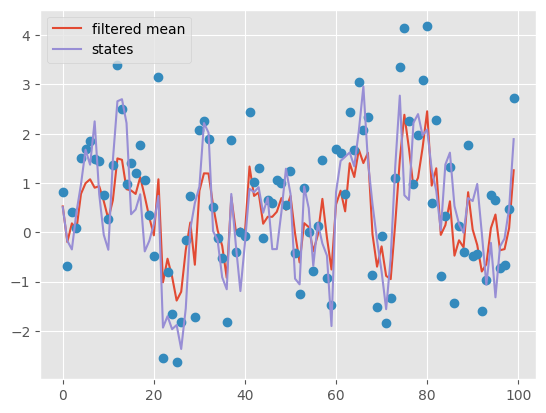

In [ ]:
plt.plot([m['mean'] for m in bf.summaries.moments],
         label='filtered mean')
plt.plot(data, 'o')
plt.plot(true_states, label="states")
plt.legend()

We can also plot the filtered mean plus/minus two standard errors.

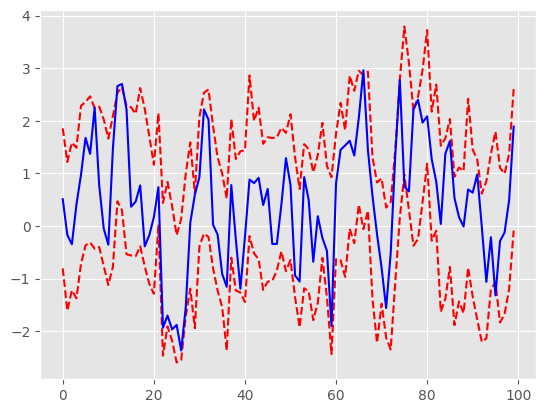

In [ ]:
plt.plot([m['mean']+2*np.sqrt(m['var']) for m in bf.summaries.moments],linestyle='dashed',
         color='red')
plt.plot([m['mean']-2*np.sqrt(m['var']) for m in bf.summaries.moments],linestyle='dashed',
         color='red')
plt.plot(true_states, label="states",color='blue')




## Investigating the Accuracy of the Bootstrap Filter

To investiage the Monte Carlo accuracy we can look at the variability across multiple runs. To compare how features of the model affect the accuracy we need to standardise this variability by the filtering variance of the quantity. This then gives an estimate of the Monte Carlo effective sample size as ratio of Var$(X_t|y_{1:t})$ to Variance of $E(X_T|y_{1:T})$.

We can use the ```multiSMC``` to run the filter multiple times:
https://particles-sequential-monte-carlo-in-python.readthedocs.io/en/latest/notebooks/advanced_tutorial_ssm.html#Running-many-particle-filters-in-one-go

The function allows for different implementations of a filter to be run -- so the arguments are the general bootstrap filter we define (```fk_model```) and the arguments (here the number of particle ```N=100```) and the number of runs of the filter (```nruns=100```). To save storage you can specify the functions to store.

In [ ]:

results = particles.multiSMC(fk=fk_model,nruns=100,N=100)

This produces a list of the results for each run. We can then create lists of the filtered mean/variance for each run to calculate the ESS.

In [ ]:
filter_means=[] ## list of filtered means
filter_vars=[] ##list of filtered variances
for r in results:
    mean = np.sum(r['output'].X*r['output'].W) ##mean for the run
    mean_sq = np.sum(r['output'].X**2 * r['output'].W) ## mean square for the run
    filter_means.append(mean)
    filter_vars.append(  (mean_sq- mean**2) )

ESS_across_runs = np.mean(filter_vars)/np.var(filter_means)
ESS_across_runs

12.201164939395838

This should be between the number of particles (```N=100```) and 1. The latter would suggest that the filter is as efficient as getting IID samples from the filtering distribution.

**Investigation**

Re-run the code for this model and investigate how the following affects the Effective Sample Size:
1. The number of particles
2. The number of time-steps (does the accuracy reduce as t increases?)
3. The observation variance
4. The value of rho (which should be in the interval $[0,1)$ )
5.  A large variance for $X_0$: and how this affects the accuracy at different values of t.

For (3)-(5) it is best to make a big change. (The behaviour for rho particularly depends on how close it is to 1. So ```rho=0.99``` may behave very differentaly from ```rho=0.9```.)

Below I give two examples for doing this.


In [ ]:
results = particles.multiSMC(fk=fk_model,nruns=100,N=400) ##evaluating the affect of increasing the number of particles.

filter_means=[] ## list of filtered means
filter_vars=[] ##list of filtered variances
for r in results:
    mean = np.sum(r['output'].X*r['output'].W) ##mean for the run
    mean_sq = np.sum(r['output'].X**2 * r['output'].W) ## mean square for the run
    filter_means.append(mean)
    filter_vars.append(  (mean_sq- mean**2) )

ESS_across_runs = np.mean(filter_vars)/np.var(filter_means)

##The ESS should increase roughly linearly with N, the number of particles.

ESS_across_runs



66.5526796654276

In [ ]:
linearssm_accurate_obs = LinearGaussianSSM(rho=0.5,sigma=0.1) ##define a ssm with observation variance 0.1^2

##resimulate data and run bootstrap filter
true_states2, data2 = linearssm_accurate_obs.simulate(100) #simulate one hundred data points
fk_model = ssm.Bootstrap(ssm=linearssm_accurate_obs, data=data2)  # we use the Bootstrap filter

results = particles.multiSMC(fk=fk_model,nruns=100,N=100) ##evaluating the affect of increasing the number of particles.

filter_means=[] ## list of filtered means
filter_vars=[] ##list of filtered variances
for r in results:
    mean = np.sum(r['output'].X*r['output'].W) ##mean for the run
    mean_sq = np.sum(r['output'].X**2 * r['output'].W) ## mean square for the run
    filter_means.append(mean)
    filter_vars.append(  (mean_sq- mean**2) )

ESS_across_runs = np.mean(filter_vars)/np.var(filter_means)

##for more accurate observations the Monte Carlo error for the bootstrap filter is often greater (so small ESS) as the Importance Sampling step is less efficient.

ESS_across_runs




30.48583643201572

## Direct Parameter Estimation

One approach to estimating parameters is to add the parameter as part of the state. Call the latent state $X'$ then $X_t=(X'_t,\theta)$ and the filtered distribution is $p(X'_t,\theta|y_{1:t})$ whose marginal is the posterior $p(\theta|y_{1:t})$.

In general this does not work well as the diversity of the parameter values amongst the particles decays.

We will investigate this. First we need to define the linear State Space Model but add rho to the state. We will estimate rho and use an uniform prior on $[0,1]$ for rho.

To do this we use ```dists.StructDist()``` to define a vector random variable where each component is independent and named.

In [ ]:
class LinearGaussianSSM_rho_unknown(ssm.StateSpaceModel):
    default_params = {'sigma': 1., 'tau': 1., 'priorsd':1.}  # optional
    def PX0(self):  # Distribution of X_0
        return dists.StructDist({'X':dists.Normal(scale=self.priorsd), 'rho':dists.Beta()}) # X_0 ~ N(0, priorsd^2), rho | Beta(1,1) [i.e. uniform]
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}
        return dists.StructDist({'X':dists.Normal(loc=xp['X'] * xp['rho'], scale=self.tau * np.sqrt( 1. - xp['rho']**2) ), 'rho':dists.Dirac(loc=xp['rho']) }) # X_t ~ N( rho*X_{t-1}, tau^2 * (1-rho^2)); rho is unchanged
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t (and X_{t-1})
        return dists.Normal(loc=x['X'], scale=self.sigma)  # Y_t ~ N(X_t, sigma^2)

We will simulate data with a known value of ```rho``` (set to 0.9). To do this we simulate using ```LinearGaussianSSM```, but then use the bootstrap filter for ```LinearGaussianSSM_rho_unknown``` to estimate the filter distribution for $X_t$ and ```rho```.

In [ ]:
linearssm = LinearGaussianSSM(rho=0.9)
true_states, data = linearssm.simulate(100) #simulate one hundred data points for rho=0.9

linearssm_rho_estimate =  LinearGaussianSSM_rho_unknown()
fk_model2 = ssm.Bootstrap(ssm=linearssm_rho_estimate, data=data)


bf = particles.SMC(fk=fk_model2, N=1000, resampling='multinomial', ESSrmin=1.)  # the algorithm, have changed the resampling to multinomial to emphasise the degeneracy issue we observe


We will now run the bootstrap filter iteration by iteration and plot a histogram of the weighted particles. For this we use the command ```next```.

The first block of code runs the filter for the first data point. The subsequent block runs it for the next nine data points. After each run we plot a histogram of the weighted particles. Re-run the second block of code to see how the particles for ```rho``` degenerate as $t$ increases.

1


Text(0.5, 1.0, 'rho')

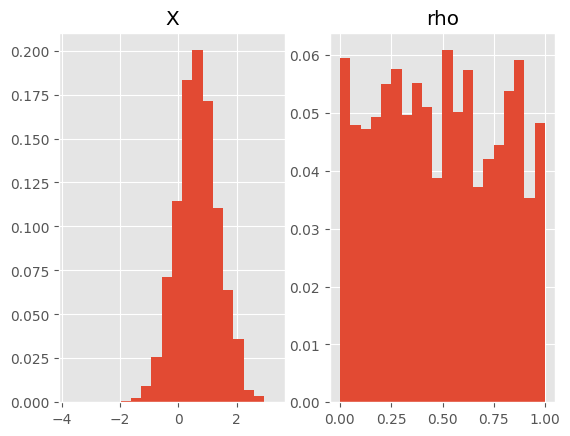

In [ ]:
next(bf) #process data[0]

print(bf.t) ##print time-point

figure, (ax1,ax2) = plt.subplots(1, 2)
ax1.hist(bf.X['X'], 20, weights=bf.W) ##histogram for weighted sample
ax1.set_title('X')
ax2.hist(bf.X['rho'],20, weights=bf.W) ##histogram for rho
ax2.set_title('rho')


Text(0.5, 1.0, 'rho; t=10')

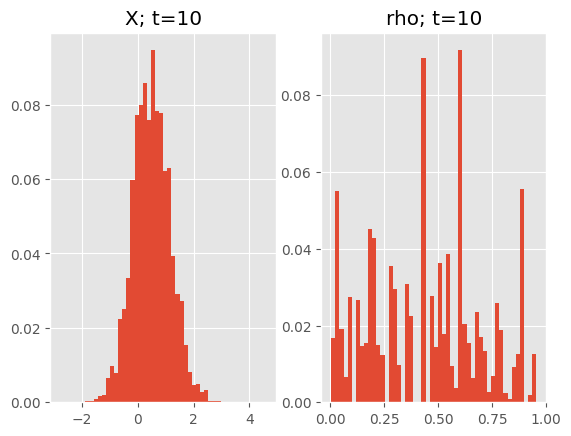

In [ ]:
##now process 9 observations at a time and histograms -- repeat to see after each batch of observations
for i in range(9):
    next(bf) #process data the next 9 data points in turn.

figure, (ax1,ax2) = plt.subplots(1, 2)
ax1.hist(bf.X['X'], 50, weights=bf.W) ##histogram for weighted sample
ax1.set_title('X; t=%i' %bf.t)
ax2.hist(bf.X['rho'],50, weights=bf.W) ##histogram for rho
ax2.set_title('rho; t=%i' %bf.t)

You should see that for large $t$, the posterior for ```rho``` converges to a small set of distinct values. For large enough $t$ the posterior approximation will be a point mass. That is all particles will have the same value of 'rho'.

This degeneracy occurs because the filter does only resamples ```rho``` values (which can only get rid of values) and propagates them exactly (so does not produce new values). This contrasts with the ```X``` value, as the transition process will produce different values for $X_t$ for multiple identical copies of $X_{t-1}$.

This degeneracy would occur more slowly if we had used residual sampling rather than multinomial sampling -- try this out.

## Fixed-Lag Smoothing

There is a simple way of doing smoothing with the bootstrap filter. This is by expanding the state at time $t$ to contain the complete path of the state up to time $t$. For a similar reason to the simple approach to parameter estimation, this often performs poorly as historical values of the state cannot change and thus you see particle degeneracy.

A related idea is fixed-lag smoothing where you are interested in the history of the state proess up to some lag $L$ in the past. This is better as if $L$ is small enough then the affect of particle degeneracy may not be too bad.

We will investigate this (in the particles package the state is of fixed size, so the naive smoothing approach is difficult to implement; we will just do fixed-lag smoothing).

We use ```dists.IndepProb``` to define a multivariate distribution for the state which is independent across components, and ```dists.Dirac``` to denote a point mass for the (deterministic) transition of the historic components of the state. The prior for $X_0$ has arbitrary place-holders for the undefined historic values of the state.

In [ ]:
class LinearGaussianSSM_fixed_lag5(ssm.StateSpaceModel): ##adaptation of state space model to allow for fixed-lag smoothing to time 5 in the past.
    ##the particles package does not give a simple way of doing this as the dirac distribution is only univariate.
    default_params = {'sigma': 1., 'rho': 0.8, 'tau': 1., 'priorsd':1.}  # optional
    def PX0(self):  # Distribution of X_0
        return dists.IndepProd(
            dists.Normal(scale=self.priorsd),
            dists.Dirac(loc=0),
            dists.Dirac(loc=0),
            dists.Dirac(loc=0),
            dists.Dirac(loc=0),
            dists.Dirac(loc=0),
        ) # X_0 ~ N(0, priorsd^2), ##initital X_{-1},..X{-5} to be 0 as placeholder
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}
        return dists.IndepProd(
            dists.Normal(loc=self.rho * xp[:,0], scale=self.tau * np.sqrt( 1. - self.rho**2) ),
            dists.Dirac(loc=xp[:,0]),
            dists.Dirac(loc=xp[:,1]),
            dists.Dirac(loc=xp[:,2]),
            dists.Dirac(loc=xp[:,3]),
            dists.Dirac(loc=xp[:,4]),
        ) # X_t ~ N( rho*X_{t-1}, tau^2*(1-rho^2)), then X[k]=Xp[k-1] as X_{t-k}=X_{(t-1)-(k-1)} so we copy across
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t (and X_{t-1})
        return dists.Normal(loc=x[:,0], scale=self.sigma)  # Y_t ~ N(X_t, sigma^2)

In [ ]:
linearssm_fixed_lag5 = LinearGaussianSSM_fixed_lag5(rho=0.5,sigma=0.3)
##smaller sigma -- IS per iteration is worse for bootstrap filter and hence degeneracy is worse

true_states, data = linearssm_fixed_lag5.simulate(20) #simulate 20 data points

In [ ]:
true_states ##see how the state vector evolves -- with state values moving back through the state vector

[array([[-1.9256629,  0.       ,  0.       ,  0.       ,  0.       ,
          0.       ]]),
 array([[-1.71468753, -1.9256629 ,  0.        ,  0.        ,  0.        ,
          0.        ]]),
 array([[-1.4022359 , -1.71468753, -1.9256629 ,  0.        ,  0.        ,
          0.        ]]),
 array([[-1.91079504, -1.4022359 , -1.71468753, -1.9256629 ,  0.        ,
          0.        ]]),
 array([[-0.38674527, -1.91079504, -1.4022359 , -1.71468753, -1.9256629 ,
          0.        ]]),
 array([[-1.39017564, -0.38674527, -1.91079504, -1.4022359 , -1.71468753,
         -1.9256629 ]]),
 array([[-0.2106908 , -1.39017564, -0.38674527, -1.91079504, -1.4022359 ,
         -1.71468753]]),
 array([[-0.13774607, -0.2106908 , -1.39017564, -0.38674527, -1.91079504,
         -1.4022359 ]]),
 array([[ 0.34759418, -0.13774607, -0.2106908 , -1.39017564, -0.38674527,
         -1.91079504]]),
 array([[ 1.30844328,  0.34759418, -0.13774607, -0.2106908 , -1.39017564,
         -0.38674527]]),
 array([[-1.0022

In [ ]:
##now look at the performance of the bootstrap filter
fk_model3 = ssm.Bootstrap(ssm=linearssm_fixed_lag5, data=data)
bf = particles.SMC(fk=fk_model3, N=100, resampling='multinomial', ESSrmin=1.)  # the algorithm, have changed the resampling to multinomial to emphasise the degeneracy issue we observe
bf.run()

The above sets up the boostrap filter with multinomial sampling and runs it. We can now look at the diversity of the particles at different lags, l, by varying 'l' in the following.

(array([1.78589086e-11, 0.00000000e+00, 2.20822899e-09, 9.23972462e-09,
        0.00000000e+00, 1.46105117e-07, 0.00000000e+00, 9.84108950e-07,
        0.00000000e+00, 6.74132215e-06, 4.24766437e-05, 3.00668210e-04,
        3.89411749e-04, 0.00000000e+00, 3.23321707e-03, 2.90075794e-03,
        6.27355673e-03, 1.63781974e-02, 2.49361266e-02, 5.51628999e-02,
        5.41197553e-02, 2.34477020e-02, 1.09045908e-01, 3.09412307e-02,
        1.28816346e-01, 1.25800113e-01, 1.14435517e-01, 9.52587526e-02,
        7.68637905e-02, 2.75869892e-02, 2.16244751e-02, 3.31569529e-02,
        3.31869748e-02, 1.33745454e-02, 9.78932633e-04, 4.91734268e-04,
        1.21441475e-03, 0.00000000e+00, 0.00000000e+00, 1.13463027e-05,
        1.24562785e-05, 6.86091226e-06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.41353914e-09, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.20643546e-11]),
 array([-1.97801511, -1.89858931, -1.81916352, -1.73973772, -1.66031193,
        -1.58088613, 

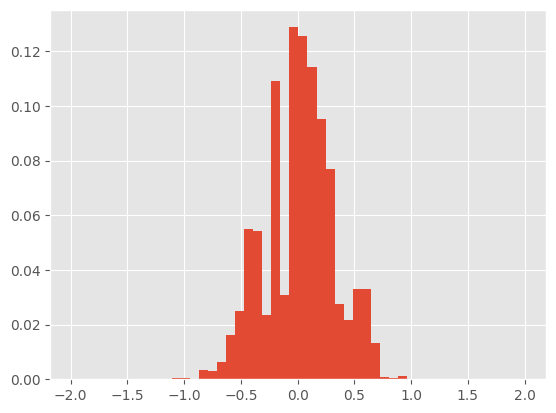

In [ ]:
l=0 ##current state change to 1..5 for lag 1..5
plt.hist(bf.X[:,l],50, weights=bf.W)

## Application to Epidemic Model

We will now try out the bootstrap filter on a simple SIR model. The state will be $X_t=(S_t,I_t)$. The model will have four parameters:
* ```N``` -- the population size = $S_0+I_0$
* ```I0``` -- the initial number of infectives
* ```beta``` -- the scaled infection rate per pair, so infection of one susceptible at rate $\beta I_t/N$
* ```rho``` -- the recovery rate
* ```p``` -- the parameter of the likelihood model (we use a Poisson model; a Binomial model appears to give numerical issues, perhaps due to how ```particles``` calculates the log-likelihod for the Binomial when the likelihood is 0).

Here we want to try a model where we observe the $S$ to $I$ transitions.

We will augment the state to include the number of transitions from $S$ to $I$ and from $I$ to $R$. This is needed due to how the ```particles``` package constructs (non-standard) multivariate distributions.

In [ ]:
class SIR(ssm.StateSpaceModel):
    default_params = {'N': 100, 'I0': 5, 'beta': 0.5, 'gamma': 0.4, 'p': 0.5}  # optional

    def PX0(self):  # Distribution of X_0 =(Z_StoI,Z_ItoR,S,I) the first two entries are place holders
        prior = dists.OrderedDict() ##ordering matters due to conditional simulation in PX
        prior['ZtoI'] = dists.Dirac(self.I0)
        prior['ZtoR'] = dists.Dirac(0)
        prior['S'] = dists.Dirac(self.N-self.I0 )
        prior['I'] = dists.Dirac(self.I0)
        return dists.StructDist(prior)

    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}
        chainrule=dists.OrderedDict()
        #we simulate the number transitions from S to I (ZtoI) and I to R (ZtoR) and then
        #the new states are defined as Dirac (i.e. deterministic) distributions condtional on these.
        # Ensure p is within [0, 1]
        p = 1. - np.exp(-self.beta * xp['I'] / self.N)
        p = np.clip(p, 0, 1)  # Clip values to be within [0, 1]
        I = int(xp['I'][0])
        if(I < 0):
          I = 0
        S = int(xp['S'][0])
        if(S < 0):
          S = 0
        chainrule['ZtoI'] = dists.Binomial(n=S, p=p)
        chainrule['ZtoR'] = dists.Binomial(n=I,p=1.-np.exp(-self.gamma))
        chainrule['S'] = dists.Cond(lambda x: dists.Dirac(S-x['ZtoI']) )
        chainrule['I'] = dists.Cond(lambda x: dists.Dirac(I+x['ZtoI']-x['ZtoR']) )
        return dists.StructDist(chainrule)

    def PY(self, t, xp, x):  # Distribution of Y_t given X_t (and X_{t-1})
        return dists.Poisson(x['ZtoI'] * self.p)

In [ ]:
SIRssm = SIR()
SIR_true_states, SIR_data = SIRssm.simulate(20)
print(SIR_true_states)

[array([(5., 0., 95., 5.)],
      dtype=[('ZtoI', '<f8'), ('ZtoR', '<f8'), ('S', '<f8'), ('I', '<f8')]), array([(3, 1, 92., 7.)],
      dtype=[('ZtoI', '<i8'), ('ZtoR', '<i8'), ('S', '<f8'), ('I', '<f8')]), array([(1, 2, 91., 6.)],
      dtype=[('ZtoI', '<i8'), ('ZtoR', '<i8'), ('S', '<f8'), ('I', '<f8')]), array([(4, 3, 87., 7.)],
      dtype=[('ZtoI', '<i8'), ('ZtoR', '<i8'), ('S', '<f8'), ('I', '<f8')]), array([(1, 1, 86., 7.)],
      dtype=[('ZtoI', '<i8'), ('ZtoR', '<i8'), ('S', '<f8'), ('I', '<f8')]), array([(2, 2, 84., 7.)],
      dtype=[('ZtoI', '<i8'), ('ZtoR', '<i8'), ('S', '<f8'), ('I', '<f8')]), array([(2, 4, 82., 5.)],
      dtype=[('ZtoI', '<i8'), ('ZtoR', '<i8'), ('S', '<f8'), ('I', '<f8')]), array([(2, 0, 80., 7.)],
      dtype=[('ZtoI', '<i8'), ('ZtoR', '<i8'), ('S', '<f8'), ('I', '<f8')]), array([(1, 4, 79., 4.)],
      dtype=[('ZtoI', '<i8'), ('ZtoR', '<i8'), ('S', '<f8'), ('I', '<f8')]), array([(4, 2, 75., 6.)],
      dtype=[('ZtoI', '<i8'), ('ZtoR', '<i8'), ('S', '

We now run the bootstrap filter



In [ ]:
fk_model_SIR = ssm.Bootstrap(ssm=SIRssm, data=SIR_data)  # we use the Bootstrap filter
bf = particles.SMC(fk=fk_model_SIR, N=100, resampling='residual', ESSrmin=1. )  # the algorithm
bf.run()  # actual computation

print(bf.X)

[(1, 4, 29.,  7.) (1, 6, 29.,  5.) (2, 2, 28., 10.) (1, 3, 29.,  8.)
 (1, 3, 29.,  8.) (1, 3, 29.,  8.) (3, 4, 27.,  9.) (3, 2, 27., 11.)
 (2, 2, 28., 10.) (2, 2, 28., 10.) (1, 4, 29.,  7.) (1, 4, 29.,  7.)
 (1, 4, 29.,  7.) (2, 2, 28., 10.) (2, 3, 28.,  9.) (2, 2, 28., 10.)
 (1, 5, 29.,  6.) (1, 4, 29.,  7.) (1, 2, 29.,  9.) (6, 4, 24., 12.)
 (1, 6, 29.,  5.) (1, 3, 29.,  8.) (1, 4, 29.,  7.) (1, 1, 29., 10.)
 (3, 3, 27., 10.) (4, 4, 26., 10.) (4, 2, 26., 12.) (1, 5, 29.,  6.)
 (2, 1, 28., 11.) (1, 3, 29.,  8.) (0, 2, 30.,  8.) (0, 4, 30.,  6.)
 (0, 6, 30.,  4.) (1, 3, 29.,  8.) (1, 5, 29.,  6.) (1, 2, 29.,  9.)
 (1, 1, 29., 10.) (3, 5, 27.,  8.) (2, 2, 28., 10.) (2, 6, 28.,  6.)
 (2, 4, 28.,  8.) (1, 3, 29.,  8.) (1, 6, 29.,  5.) (1, 4, 29.,  7.)
 (3, 5, 27.,  8.) (0, 3, 30.,  7.) (3, 4, 27.,  9.) (1, 3, 29.,  8.)
 (2, 4, 28.,  8.) (2, 3, 28.,  9.) (1, 5, 29.,  6.) (1, 2, 29.,  9.)
 (1, 3, 29.,  8.) (2, 3, 28.,  9.) (5, 3, 25., 12.) (1, 3, 29.,  8.)
 (1, 5, 29.,  6.) (2, 2, 28., 10.)

We can look at the approximation to the filtered density at each time step. Here we run one step of the bootstrap filter and plot the marginal histogram for $S_t$ and $I_t$. Repeat running the last block of code to see the estimates for increasing $t$.

In [ ]:
bf = particles.SMC(fk=fk_model_SIR, N=2000, resampling='residual', ESSrmin=0.5 )  # the algorithm


Text(0.5, 1.0, 'S')

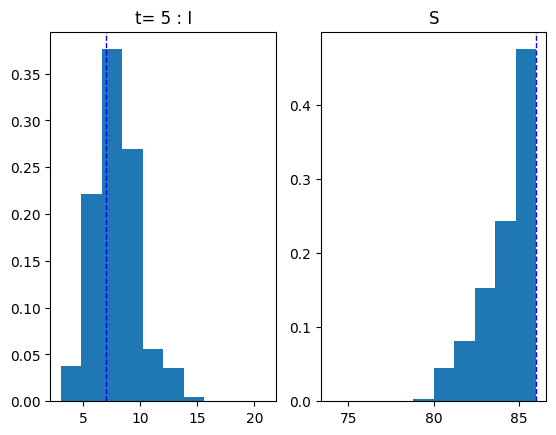

In [ ]:
next(bf)

###plot filtered estimate of S
I = [m['I'] for m in bf.X]
S = [m['S'] for m in bf.X]

figure, (ax1,ax2) = plt.subplots(1, 2)
ax1.hist(I, weights=bf.W) ##histogram for weighted sample
ax1.axvline(SIR_true_states[bf.t -1]['I'], color='blue', linestyle='dashed', linewidth=1)
ax1.set_title('t= %i : I' % bf.t)

ax2.hist(S, weights=bf.W) ##histogram for rho
ax2.axvline(SIR_true_states[bf.t -1]['S'], color='blue', linestyle='dashed', linewidth=1)
ax2.set_title('S')


Even for this simple model we can see some of the challenges of estimating the state. In particular as we only observe the new infections (with substantial noise) rather than the states themselves, it can be hard to accurately estimate the state.

**Investigation**

Try implementing different likelihood models, such as observing the exact number of new infections, and see how accurately you can estimate the states.